# PUBG Data Analysis

In [31]:
import pandas as pd
import numpy as np

df = pd.read_csv(r'data\pubg_spatiotemporal_stat.csv')

id = np.unique(df['Match ID'])

mask = df['Map'] == 'ERANGEL'
# mask = df['Map'] == 'MIRAMAR'
df_ = df[mask]

# dfs = []
# for i in id:
#     mask = df['Match ID'] == i
#     dfs.append(df[mask])

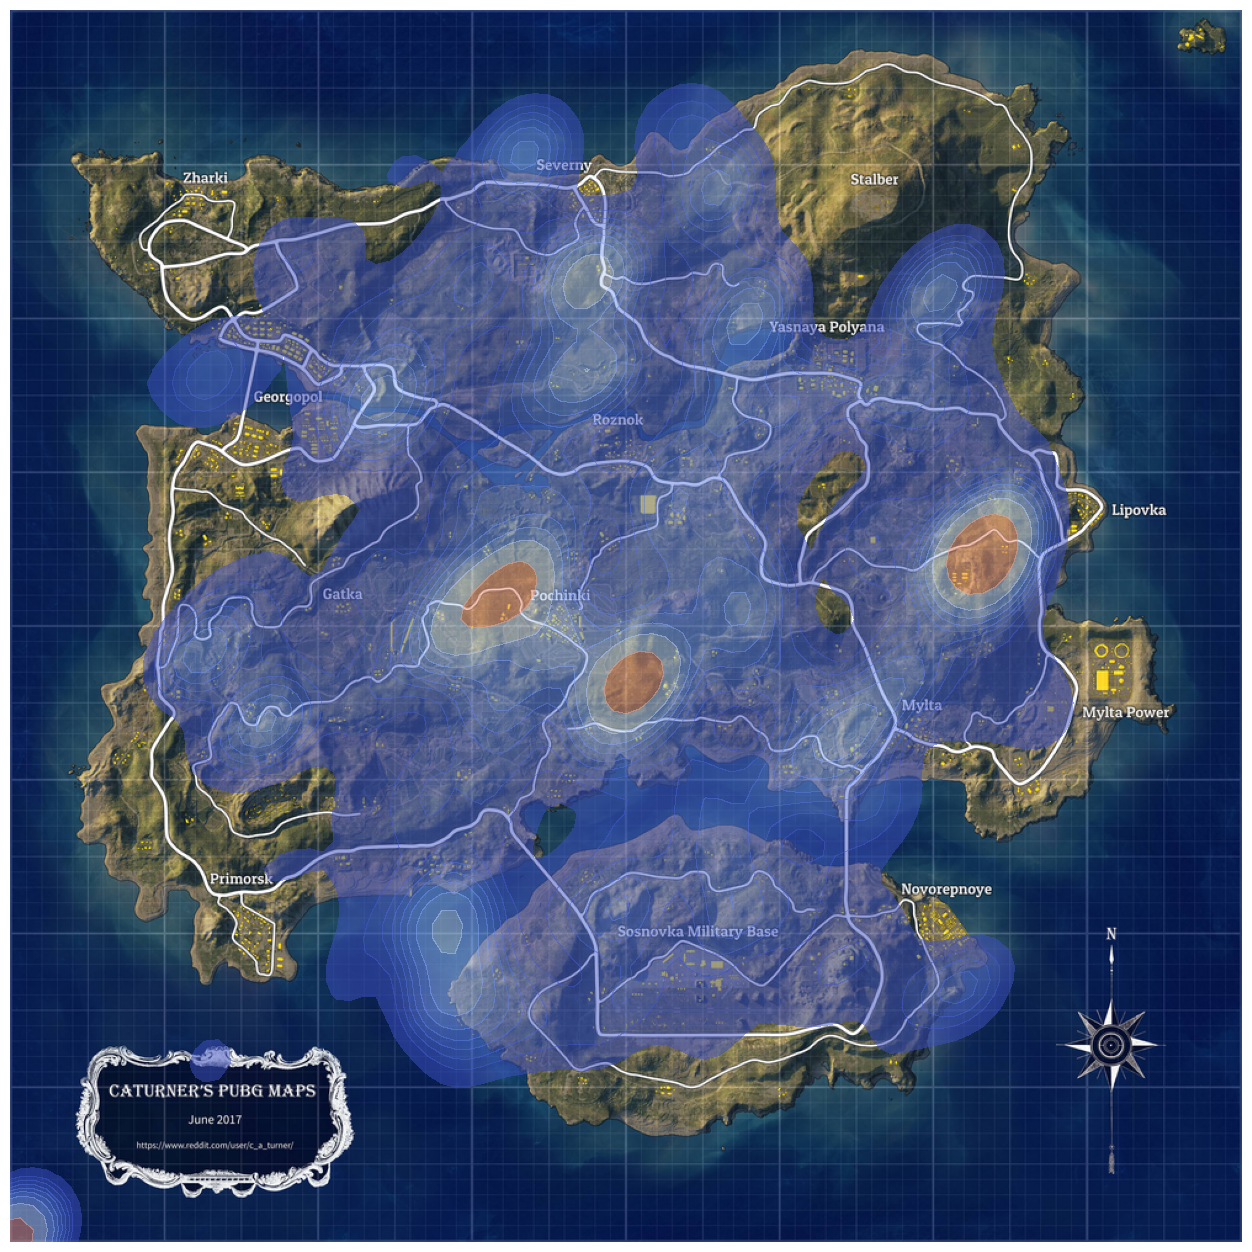

In [80]:
# coords = df_[['Victim X', 'Victim Y']].values
coords = df_[['Victim Y', 'Victim X']].values


import matplotlib.pyplot as plt
import seaborn as sns

scale = 0.8
plt.figure(figsize=[20*scale, 20*scale])
# plt.scatter(*coords.T, s = 1, zorder = 100, color = 'black')
sns.kdeplot(x = coords[:, 0], y = coords[:, 1], gridsize=100, fill=True, cmap = 'coolwarm', alpha = 0.5, bw_adjust=0.5)
plt.imshow(np.load(r'data\erangel.npy'), alpha = 1.0, extent=[0, 800000, 0, 800000], cmap='gray', origin='upper')
plt.axis('off')
plt.show()

In [96]:
D_pubg = df.sort_values(by='Time').iloc[:, -5:-2].dropna().values # [ 9284, 3 ] np


def DataDiscretizer(t_grids, s_grids):
    '''
    Args:
    - t_grids: [ n_time ] np,
    - s_grids: [ n_space ]
    '''
    pass


def DataMultiplier(t_grids):
    pass

# Discrete Hawkes Process

## Code

In [2]:
import torch
import numpy as np
import arrow
import os

class DiscreteExponentialKernel(torch.nn.Module):

    def __init__(self, obs, alpha = np.eye(99), beta = np.ones(1)):
        '''
        Args:
        - obs:      [ n_time, n_space ] torch long
        - alpha:    [ n_space, n_space ] np
        - beta:     [ 1 ] np
        '''
        super().__init__()
        self.obs    = obs 
        self.alpha  = torch.nn.Parameter(torch.tensor(alpha).float())   # [ n_space ] torch
        self.beta   = torch.nn.Parameter(torch.tensor(beta).float())    # [ 1 ] torch

    def forward(self, tp, sp, t, s):
        '''
        Args:
        - four [ batch_size ] torch
        Returns:
        - val:  [ batch_size ] torch
        '''
        obs_   = self.obs[tp, sp]   # [ batch_size ] torch  
        alpha_ = self.alpha[sp, s]  # [ batch_size ] torch  
        val    = alpha_ * obs_ * self.beta * torch.exp( - self.beta * torch.abs(t - tp))
        return val
    
    @staticmethod
    def top_k_neighbors(k):
        # TODO: select the top k nearst neightbor to be included in initialized alpha
        raise NotImplementedError

class DiscreteHawkes(torch.nn.Module):
    '''
    Reference:
    https://arxiv.org/abs/2109.09711
    '''
    def __init__(self, obs, mu, kernel_kwargs):
        '''
        Args:
        - obs:      [ n_time, n_space ] np
        - mu:       [ n_space ] np, base rate
        '''
        # init
        super().__init__()
        self.n_time, self.n_space = obs.shape
        self.obs    = torch.tensor(obs).long()                      # [ n_time, n_space ] torch
        self.kernel = DiscreteExponentialKernel(self.obs, **kernel_kwargs)
        self.mu_    = torch.nn.Parameter(torch.tensor(mu).float())  # [ n_space ] torch

    def lam(self, t, s):
        """
        Conditional intensity function lambda at x
        Args:
        - two   [ batch_size ] torch
        Return:
        - lam:  [ batch_size ] torch
        """
        # TODO: spped up algorithm by avoiding mask...
        if len(t) == 0 or len(s) == 0:
            return 0.
        batch_size  = len(t)
        max_t   = torch.max(t).long().item()    # int
        tp      = torch.arange(torch.max(t)).unsqueeze(0).unsqueeze(0).repeat(batch_size, self.n_space, 1)  # [ batch_size, n_space, max_t ] torch
        sp      = torch.arange(self.n_space).unsqueeze(0).unsqueeze(-1).repeat(batch_size, 1, max_t)        # [ batch_size, n_space, max_t ] torch
        # Step 1: Pad all redundant future times
        mask = tp < t.unsqueeze(1).unsqueeze(1).repeat(1, self.n_space, max_t)      # [ batch_size, M, max_t ] torch
        # Step 2: Transform to batch inputs
        tp_, sp_ = tp.reshape(-1), sp.reshape(-1)                                   # both [ ext_batch_size ] torch
        t_ = t.unsqueeze(1).unsqueeze(1).repeat(1, self.n_space, max_t).reshape(-1) # [ ext_batch_size ] torch
        s_ = s.unsqueeze(1).unsqueeze(1).repeat(1, self.n_space, max_t).reshape(-1) # [ ext_batch_size ] torch
        # Step 3: Feed to kernel
        val_batch   = self.kernel(tp_, sp_, t_, s_)                                 # [ extended batch size ] torch
        val         = val_batch.reshape(mask.shape) * mask                          # [ batch size, M, max_t ] torch, also padded for redundancy
        lam         = self.mu(s) + val.sum(-1).sum(-1)  # [ batch_size ] torch
        lam         = torch.nn.functional.relu(lam)     # prevent negative lam
        return lam

    def mu(self, s):
        ''' [ batch_size ] torch '''
        return self.mu_[s]  # [ batch_size ] torch

    def loglik(self):
        '''
        Returns:
        - loglik:   scalar
        - lam:      [ n_time, n_space ] torch
        '''
        t = torch.arange(self.n_time)       # [ n_time ] torch
        s = torch.arange(self.n_space)      # [ n_space ] torch
        t_grid, s_grid = torch.meshgrid(t, s, indexing='ij')
        t_grid, s_grid = t_grid.reshape(-1), s_grid.reshape(-1) # [ n_time * n_space ] torch
        lam     = self.lam(t_grid, s_grid)  # [ n_time * n_space ] torch
        obs_    = self.obs[t_grid, s_grid]  # [ n_time * n_space ] torch
        loglik  = - lam.sum() + (obs_ * torch.log(lam)).sum() 
        return loglik, lam.reshape(self.n_time, self.n_space)

    def fit(self, num_epochs, lr, save_folder):
        self.train()
        optimizer = torch.optim.Adadelta(self.parameters(), lr=lr)
        losses = []
        for iter in range(num_epochs):
            optimizer.zero_grad()
            loglik, _ = self.loglik()
            loss         = - loglik
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if iter % (num_epochs // 10) == 0:
                print(f'Time: {arrow.now()}\t Epoch: {iter :5d}\t Loss: {losses[-1] :.2f}')
        os.makedirs(save_folder, exist_ok=True)
        torch.save(self.state_dict(), save_folder + '/state_dict.pth')
        print(f'Trained model has been saved!')
        self.eval()

    def load(self, save_folder):
        state_dict = torch.load(save_folder + '/state_dict.pth')
        self.load_state_dict(state_dict)
        print('Found trained model and loaded!')

    def simulate(self, history = None, horizon = 1):
        '''
        Simulate for next some horizon of time steps based on provided history
        Args:
        - history:  [ n_hist, n_space ] np, default (None) set to be self.obs
        - horizon:  scalar
        Returns:
        - data:     [ n_space, horizon ] np
        '''
        with torch.no_grad():
            obs_ = self.obs.clone()
            self.obs = torch.tensor(history).long() if history is not None else self.obs  
            t_next = torch.ones(self.n_space).unsqueeze(-1) * torch.arange(len(self.obs), len(self.obs) + horizon)     # [ n_space, horizon ] torch
            s_next = torch.arange(self.n_space).unsqueeze(-1).repeat(1, horizon)                                       # [ n_space, horizon ] torch 
            t_next_ = t_next.reshape(-1).long()
            s_next_ = s_next.reshape(-1).long()
            lam     = self.lam(t_next_, s_next_)                                                                       # [ n_space * horizon ] torch
            lam     = lam.reshape(t_next.shape) 
            self.obs = obs_.clone()
        return lam.numpy()

## Demo

Found trained model and loaded!


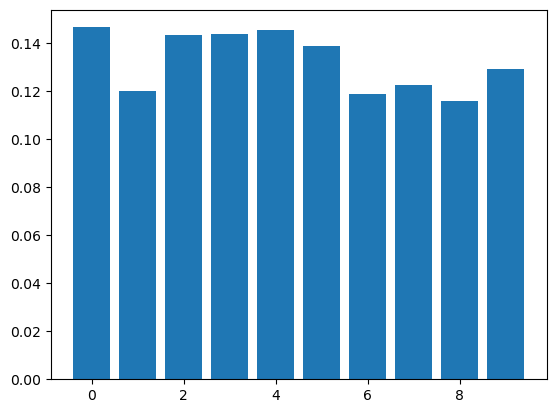

In [8]:
import matplotlib.pyplot as plt

Dtr = np.clip(np.random.randn(100, 10), a_min = 0., a_max=None)
Dte = np.clip(np.random.randn(100, 10), a_min = 0., a_max=None)

pp_kwargs = {
    'obs':      Dtr,
    'kernel_kwargs':    {
        'alpha':    1e-1 * np.eye(Dtr.shape[-1]),
        'beta':     1e-1
    },
    'mu':       1e-1 * np.ones(Dtr.shape[-1])
}

pp_fit_kwargs = {
    'num_epochs':   1000,
    'lr':           1e-3,
    'save_folder':  'cache/discrete_hawkes'  
}

pp = DiscreteHawkes(**pp_kwargs)

# pp.fit(**pp_fit_kwargs)
pp.load(pp_fit_kwargs['save_folder'])

y = pp.simulate(history=Dte, horizon=1).reshape(-1)
plt.bar(np.arange(len(y)), y)
plt.show()

# Multivariate Hawkes Process

## Code

In [51]:
import numpy as np
import torch
import torch.optim as optim
import arrow
import os
from abc import abstractmethod
from torch.utils.data import TensorDataset, DataLoader

class BaseMultivariateHawkes(torch.nn.Module):
    '''
    Hawkes model with discrete space, continuous time
    '''
    def __init__(self, T, n_space, int_res = 100):
        '''
        Args:
        - T:        list of starting time and ending time, e.g. [ 0., 30. ]
        - n_space:  int, dimension of spatial, e.g. 99
        '''
        super().__init__()
        self.T =        T 
        self.n_space =  n_space
        self.int_res =  int_res

        # # model params
        # self._mu        = torch.nn.Parameter(torch.ones(S_dim, dtype=float))        # [ number of spatial nodes ]
        # self.kernel     = ExponentialKernel(self.locs)                              # [ batch size, 2 ] and [ batch size, 2 ] -> [ batch size ]

    def fit(self, data, batch_size, num_epochs, lr, save_folder):
        '''
        Args:
        - data:         [ seq_len, data_dim ], numpy or torch
        - save_folder:  save folder of model dict
        Returns:
        - model's state dict
        - model's training log
        '''
        # TODO: extend to batch version
        self.train()
        data            = data.reshape(1, *data.shape) if len(data.shape) == 2 else data # [ batch_size, seq_len, data_dim ]
        data            = torch.tensor(data).float() if isinstance(data, np.ndarray) else data
        traindataset    = TensorDataset(data)
        trainloader     = DataLoader(traindataset, batch_size=batch_size, shuffle=True)

        opt = optim.Adadelta(self.parameters(), lr=lr)
        losses = []
        for i in range(num_epochs):
            epoch_losses = []
            for data in trainloader:    # [ batch_size, seq_len, data_dim ] torch
                opt.zero_grad()
                x_  = data[0][0]        # [ seq_len, data_dim ] torch
                loglik      = self(x_)
                loss        = - loglik.mean()
                loss.backward()
                opt.step()
                epoch_losses.append(loss.item())
            losses.append(np.mean(epoch_losses))

            if i % (num_epochs // 10) == 0:
                print(f"[{arrow.now()}] Epoch : {i} \t Loss : {losses[-1]:.5e}")

        os.makedirs(save_folder, exist_ok=True)
        torch.save(self.state_dict(), save_folder + '/state_dict.pth')
        np.save(save_folder + '/losses.npy', np.array(losses))
        print('Model has been trained!')
        self.eval()

    def load(self, save_folder):
        self.load_state_dict(torch.load(save_folder + '/state_dict.pth'))

    def lam(self, x, h):
        '''
        Args:
        - x   : [ batch size, 2 ] torch or torch scalar
        - h   : [ batch size, history length, 2 ] torch
        Returns:
        - lam : [ batch size ] torch  
        '''
        shape   = h.shape 
        if shape[0] == 0 or shape[1] == 0:
            return torch.tensor(0.) # scalar
        # Step 1: get baserate
        mu      = self.mu(x)                        # [ batch_size ]
        # Step 2: get kernel term
        x_ext   = x.unsqueeze(1).repeat(1, shape[1], 1)                                # [ batch size, history length, 2 ] torch
        x_batch, h_batch = x_ext.reshape(-1, shape[-1]), h.reshape(-1, shape[-1])   # both [ mod batch size, 2 ] torch
        val     = self.kernel(x_batch, h_batch)     # [ mod batch_size ]
        val     = val.reshape(shape[0], shape[1])   # [ batch size, history length ]
        # mask all paddings
        mask    = h[:, :, 0] != 0.                  # [ batch size, history length ] torch 
        val     = val * mask                        # [ batch size, history length ] torch 
        lam     = mu + val.sum(-1)                  # [ batch size ] torch
        lam     = torch.relu(lam)                   # [ batch_size ] torch
        return lam                                  # [ batch size ] torch
    
    def simulate(self, data, t_start, t_end, ls_kwargs = {}, verbose = False):
        '''
        Using efficient multivariate hawkes thinning algorithm described in
        https://www.math.fsu.edu/~ychen/research/multiHawkes.pdf

        Args:
        - data:         [ seq_len >= 0, data_dim ] np, history data 
        - t_start:      starting simulation time
        - t_end:        ending simulation time
        - ls_kwargs:    kwargs passed to LambdaScheduler class
        Returns:
        - sim_traj:     [ seq_len, data_dim ] numpy, simulated trajectory
        - x:
        '''
        # TODO: verbose method
        assert len(data.shape) == 2, f'Expected data of dimension [ seq_len, data_dim ], got {data.shape}'
        data    = torch.tensor(data).float()    # [ seq_len, data_dim ] torch
        ls      = LambdaScheduler(**ls_kwargs)
        retained_points = [x for x in data]

        t = t_start
        while t < t_end:
            s_grids = torch.arange(self.n_space)                    # [ n_space ] torch
            ts      = torch.ones(self.n_space) * t                  # [ n_space ] torch
            xs      = torch.stack([ts, s_grids], -1)                # [ n_space, 2 ] torch 
            hs      = torch.stack(retained_points, 0).unsqueeze(0).repeat(self.n_space, 1, 1)    # [ n_space, seq_len, data_dim ] torch
            lams    = self.lam(xs, hs)                              # [ n_space ] torch
            lam_bar = ls()    # torch scalar
            
            if lam_bar < lams.sum():
                ls.step(False)
                continue
            
            u = torch.rand(1) # torch scalar
            w = - torch.log(u) / lam_bar
            t = t + w
            D = torch.rand(1) # torch scalar

            try: # TODO: index 0 is out of bounds for dimension 0 with size 0 (index = torch.where(mask)[0][0].item() + 1)
                if D * lam_bar <= lams.sum():
                    mask  = D * lam_bar <= lams.cumsum(-1)      # [ n_space ] torch
                    index = torch.where(mask)[0][0].item()      # int 
                    x     = torch.tensor([t, index])            # [ 2 ] torch
                    retained_points.append(x)
            except:
                pass

        retained_points = retained_points[len(data):]       # remove all history values

        try:
            if t > t_end:
                sim_traj = torch.stack(retained_points[:-1], 0) # [ seq_len, 2 ] torch
            else:
                sim_traj = torch.stack(retained_points, 0)      # [ seq_len, 2 ] torch
        except: # zero length sim_traj encountered
            sim_traj = torch.tensor([]).reshape(0, 2)
        sim_traj = sim_traj.detach().numpy() # [ seq_len, 2 ] numpy
        return sim_traj
    
    def loglik(self, data):
        '''
        Args:
        - data      : [ number of datapoints, 2 ] torch
        Returns:
        - loglik    : torch float
        '''
        points, histories = [], []
        for i in range(len(data)):
            point, history = data[i], data[:i] # [ 2 ] and [ history length, 2 ] torch
            # padding value is 0.
            history = torch.nn.functional.pad(history, pad=(0, 0, 0, len(data)-len(history)), value=0.)   # [ max history length, 2 ]
            points.append(point)
            histories.append(history)
        points    = torch.stack(points, 0)      # [ number of datapoints, 2 ]
        histories = torch.stack(histories, 0)   # [ number of datapoints, max history length, 2 ]
        lams      = self.lam(points, histories) # [ number of datapoints ] torch

        # see Reinhart's review of point process Eq.(8)
        term1 = torch.log(lams).sum()                               # scalar torch
        term2 = self.integral_term(data).sum() * self.T[-1] / self.int_res   # scalar torch
        loglik = term1 - term2
        return loglik                           # scalar torch

    def integral_term(self, data,
                      T = None, int_res = None):
        '''
        Args:
        - T                 : list of starting time and ending time, e.g. [ 0., 30. ], default uses the same as the training data
        - data              : [ number of datapoints, 2 ] np or torch
        Returns:
        - lams              : [ number of time grids, number of spatial nodes ] torch
        '''
        if T is None:
            T = self.T
        if int_res is None:
            int_res = self.int_res
        data = torch.tensor(data).float() if isinstance(data, np.ndarray) else data # [ number of datapoints, 2 ] torch

        t_grids = torch.linspace(T[0], T[1], int_res)    # [ int_res ]  torch
        s_grids = torch.arange(self.n_space)        # [ number of spatial nodes ] torch

        points, histories = [], []
        for t in t_grids:
            mask    = data[:, 0] < t
            history = data[mask]
            history = torch.nn.functional.pad(history, pad=(0, 0, 0, len(data)-len(history)), value=0.)   # [ max history length, 2 ]
            for s in s_grids:
                point = torch.tensor([t, s]) # [ 2 ] torch
                points.append(point)
                histories.append(history)
        points    = torch.stack(points, 0)       # [ spatial * temporal grids, 2 ]
        histories = torch.stack(histories, 0)    # [ spatial * temporal grids, max history length, 2 ]
        lams = self.lam(points, histories)
        lams = lams.reshape(len(t_grids), len(s_grids)) # [ number of time grids, number of spatial nodes ] torch
        return lams # [ number of time grids, number of spatial nodes ] torch
    
    # @abstractmethod
    def forward(self, x):
        '''[ batch_size, seq_len, data_dim ] torch'''
        return self.loglik(x)   # return conditional intensities and corresponding log-likelihood
    
    @abstractmethod
    def mu(self, *args):
        """
        return base intensity
        """
        raise NotImplementedError()
    
class ExponentialMultivariateKernel(torch.nn.Module):

    def __init__(self, alpha, beta):
        '''
        Args:
        - alpha:    [ n_space, n_space ] np
        - beta:     [ 1 ] np
        '''
        super().__init__()
        self.alpha  = torch.nn.Parameter(torch.tensor(alpha).float())   # [ n_space ] torch
        self.beta   = torch.nn.Parameter(torch.tensor(beta).float())    # [ 1 ] torch

    def forward(self, x, xp):
        '''
        Args:
        - four [ batch_size ] torch
        Returns:
        - val:  [ batch_size ] torch
        '''
        alpha_ = self.alpha[xp[:, 1].long(), x[:, 1].long()]  # [ batch_size ] torch  
        val    = alpha_ * self.beta * torch.exp( - self.beta * torch.abs(x[:, 0] - xp[:, 0]))
        return val
    
    @staticmethod
    def top_k_neighbors(k):
        # TODO: select the top k nearst neightbor to be included in initialized alpha
        raise NotImplementedError
        
    
class ExponentialMultivariateHawkes(BaseMultivariateHawkes):

    def __init__(self, base_kwargs, kernel_kwargs, mu):
        '''
        Args:
        - mu:   [ n_space ] np
        '''
        super().__init__(**base_kwargs)
        self.kernel = ExponentialMultivariateKernel(**kernel_kwargs)
        self.mu_    = torch.nn.Parameter(torch.tensor(mu).float())                # [ n_space ] torch

    def mu(self, x):
        '''
        Args:
        - x:    [ batch_size, 2 ] torch
        Returns:
        - [ batch_size ] torch
        '''
        return self.mu_[x[:, 1].long()]  # [ batch_size ] torch 
    
class LambdaScheduler:
    '''
    Helper class
    For unstationary forecast whose future value will grow larger, which needs to tune "up" the lam_bar for thinning algorithm
    '''
    def __init__(self,
                 init_val   = 1e+2,
                 add_val    = 1e+2,
                 minus_val  = 1e+1,
                 patience   = 100):
        '''
        Args:
        - init_val  : initial value of the lambda
        - add_val   : increment unit of lambda
        - minus_val : decrement unit of lambda
        - patience  : rounds of success before lambda is decreased
        '''
        assert add_val > minus_val, f"LambdaScheduler: Expected add_val > minus_val, got {add_val} <= {minus_val}!"
        self.init_val   = init_val
        self.patience   = patience
        self.add_val    = add_val
        self.minus_val  = minus_val
        # init params
        self.lam_bar    = self.init_val
        self.patience_count = 0

    def __call__(self):
        return self.lam_bar

    def step(self, flag):
        '''
        Args:
        - flag : boolean. True - a point has been successfully simulated.
        '''
        if flag:
            if self.patience_count >= self.patience:
                self.patience_count = 0 
                self.lam_bar -= self.minus_val
                print(f'Decreasing lam_bar from {self.lam_bar + self.minus_val} to {self.lam_bar}')
            else:
                pass
            self.patience_count += 1
        else:
            self.patience_count = 0
            self.lam_bar += self.add_val
            print(f'Increasing lam_bar from {self.lam_bar - self.add_val} to {self.lam_bar}')

    def reset(self):
        self.lam_bar = self.init_val

## Demo

In [47]:
n_space = 10
n_data  = 1000 

s = np.random.uniform(0, n_space, n_data).astype(int)
t = np.random.randn(n_data)
t = t[t.argsort()]
data = np.stack([t, s], -1)         # [ n_data, 2 ] np

kwargs = {
    'base_kwargs':      {
        'T':        [0., 1.],
        'n_space':  n_space,
        'int_res':  10
    },
    'kernel_kwargs':    {
        'alpha':    np.eye(n_space) * 1e-1,
        'beta':     1e-1 
    }, 
    'mu':           np.ones(n_space)
}

fit_kwargs = {
    'data':         data,
    'batch_size':   124,
    'num_epochs':   10,
    'lr':           1e-1,
    'save_folder':  'cache/multivariate_hawkes'
}

model = ExponentialMultivariateHawkes(**kwargs)
model.fit(**fit_kwargs)

[2025-01-17T14:56:28.797288-05:00] Epoch : 0 	 Loss : -3.36719e+02
[2025-01-17T14:56:29.070050-05:00] Epoch : 1 	 Loss : -3.46632e+02
[2025-01-17T14:56:29.209534-05:00] Epoch : 2 	 Loss : -3.56695e+02
[2025-01-17T14:56:29.331996-05:00] Epoch : 3 	 Loss : -3.66813e+02
[2025-01-17T14:56:29.557937-05:00] Epoch : 4 	 Loss : -3.76940e+02
[2025-01-17T14:56:29.754547-05:00] Epoch : 5 	 Loss : -3.87051e+02
[2025-01-17T14:56:29.913166-05:00] Epoch : 6 	 Loss : -3.97132e+02
[2025-01-17T14:56:30.031942-05:00] Epoch : 7 	 Loss : -4.07171e+02
[2025-01-17T14:56:30.145487-05:00] Epoch : 8 	 Loss : -4.17163e+02
[2025-01-17T14:56:30.281049-05:00] Epoch : 9 	 Loss : -4.27103e+02
Model has been trained!


In [48]:
# model.simulate()


sim_kwargs = {
    'data':     data,
    't_start':  0.5,
    't_end':    1.3,
    'ls_kwargs':{},
    'verbose':  True
}

sim_traj = model.simulate(**sim_kwargs)

In [ ]:
# # NOTE: Copied from previous project.... 

# import numpy as np
# import torch
# from torch.optim import Adadelta
# import arrow
# import os
# from abc import abstractmethod
# import time as _time

# class BaseMultivariatePointProcess(torch.nn.Module):
#     '''
#     Hawkes model with discrete space, continuous time
#     '''
#     def __init__(self, T, S_dim,
#                  int_res    = 100):
#         '''
#         Args:
#         - T     : list of starting time and ending time, e.g. [ 0., 30. ]
#         - S_dim : int, dimension of spatial, e.g. 213
#         - locs  : [ S_dim, 2 ] numpy, spatial coordinate matrix of locations of the multivariate entries
#         -ls_kwargs
#         '''
#         super().__init__()
#         self.T      = T 
#         self.S_dim  = S_dim
#         # self.locs   = torch.from_numpy(locs) if isinstance(locs, np.ndarray) else locs
#         # self.ls     = LambdaScheduler(**ls_kwargs)
#         self.int_res = int_res

#         # # model params
#         # self._mu        = torch.nn.Parameter(torch.ones(S_dim, dtype=float))        # [ number of spatial nodes ]
#         # self.kernel     = ExponentialKernel(self.locs)                              # [ batch size, 2 ] and [ batch size, 2 ] -> [ batch size ]

#     def fit(self, data, lr, num_epochs, save_folder):
#         '''
#         Args:
#         - data : [ number of datapoints, 2 ] torch or numpy
#         Returns:
#         - model_folder: path to the point process model's folder
#         All other returns are saved in the provided save_path folder
#         - model's state dict
#         - model's training log
#         '''
#         self.train()
#         data = torch.FloatTensor(data) # [ num of datapoints, 2 ] torch

#         if os.path.exists(save_folder + '/state_dict.pth'):
#             self.load_state_dict(torch.load(save_folder + '/state_dict.pth'))
#             print('Found exisiting saved point process model. Model has been loaded.')
#         else:    
#             os.makedirs(save_folder, exist_ok=True)
#             optimizer = Adadelta(self.parameters(), lr=lr)
#             logs = []
#             for i in range(num_epochs):
#                 optimizer.zero_grad()
#                 loss      = - self.loglik(data) # float torch
#                 loss.backward()
#                 optimizer.step()
#                 log = f"[{arrow.now()}] Epoch : {i},\tTotal loss : {loss.item():.5e}"
#                 logs.append(log)
#                 if i % (num_epochs // 10) == 0:
#                     print(log)

#             # saving
#             torch.save(self.state_dict(), save_folder + '/state_dict.pth')
#             with open(save_folder + '/training_log.txt', "w") as file:
#                 for log in logs:
#                     file.write(log + '\n')
#             print(f'Point process model and training results have been saved at {save_folder}.')
#         self.eval()

#     def lam(self, x, h):
#         '''
#         Args:
#         - x   : [ batch size, 2 ] torch or torch scalar
#         - h   : [ batch size, history length, 2 ] torch
#         Returns:
#         - lam : [ batch size ] torch  
#         '''
#         shape   = h.shape 
#         if shape[0] == 0 or shape[1] == 0:
#             return torch.tensor(0.) # scalar
#         # step 1: get baserate
#         mu      = self.mu(x)                        # [ batch_size ]
#         # step 2: get kernel term
#         x_ext   = x.unsqueeze(1).repeat(1, shape[1], 1)                             # [ batch size, history length, 2 ] torch
#         x_batch, h_batch = x_ext.reshape(-1, shape[-1]), h.reshape(-1, shape[-1])   # both [ mod batch size, 2 ] torch
#         val     = self.kernel(x_batch, h_batch)     # [ mod batch_size ]
#         val     = val.reshape(shape[0], shape[1])   # [ batch size, history length ]
#         # mask all paddings
#         mask    = h[:, :, 0] != 0.                  # [ batch size, history length ] torch 
#         val     = val * mask                        # [ batch size, history length ] torch 
#         lam     = mu + val.sum(-1)                  # [ batch size ] torch
#         lam     = torch.relu(lam) # [ batch_size ] torch
#         # consider the decay-of-decay effect (saturation effect)
#         lam     = self.decay(lam, x)                # [ batch_size ] torch
#         return lam # [ batch size ]
    
#     def simulate(self, data, t_start, t_end, ls_kwargs = {}):
#         '''
#         Using efficient multivariate hawkes thinning algorithm described in
#         https://www.math.fsu.edu/~ychen/research/multiHawkes.pdf

#         Args:
#         - data:         [ seq_len, data_dim ] numpy, we allow seq_len = 0!
#         - t_start:      starting simulation time
#         - t_end:        ending simulation time
#         - ls_kwargs:    kwargs passed to LambdaScheduler class
#         Returns:
#         - sim_traj:     [ seq_len, data_dim ] numpy, simulated trajectory
#         - x:
#         '''
#         assert len(data.shape) == 2, f'Expected data of dimension [ seq_len, data_dim ], got {data.shape}'
#         data    = torch.FloatTensor(data)               # [ seq_len, data_dim ] torch
#         ls      = LambdaScheduler(**ls_kwargs)
#         retained_points = [x for x in data]

#         t = t_start
#         while t < t_end:
#             s_grids = torch.arange(1, self.S_dim + 1)               # [ number of spatial nodes ] torch
#             ts      = torch.ones(self.S_dim) * t                    # [ number of spatial nodes ] torch
#             xs      = torch.stack([ts, s_grids], -1)                # [ number of spatial nodes, 2 ] torch 
#             hs      = torch.stack(retained_points, 0).unsqueeze(0).repeat(self.S_dim, 1, 1)    # [ number of spatial nodes, seq_len, data_dim ] torch
#             lams    = self.lam(xs, hs)                              # [ number of spatial nodes ] torch
#             lam_bar = ls()    # torch scalar
            
#             if lam_bar < lams.sum():
#                 ls.step(False)
#                 continue
            
#             u = torch.rand(1) # torch scalar
#             w = - torch.log(u) / lam_bar
#             t = t + w
#             D = torch.rand(1) # torch scalar

#             try: # TODO: index 0 is out of bounds for dimension 0 with size 0 (index = torch.where(mask)[0][0].item() + 1)
#                 if D * lam_bar <= lams.sum():
#                     mask  = D * lam_bar <= lams.cumsum(-1)      # [ number of spatial nodes ] torch
#                     index = torch.where(mask)[0][0].item() + 1  # int 
#                     x     = torch.tensor([t, index])            # [ 2 ] torch
#                     retained_points.append(x)
#             except:
#                 pass

#         retained_points = retained_points[len(data):]       # remove all history values

#         try:
#             if t > t_end:
#                 sim_traj = torch.stack(retained_points[:-1], 0) # [ seq_len, 2 ] torch
#             else:
#                 sim_traj = torch.stack(retained_points, 0)      # [ seq_len, 2 ] torch
#         except: # zero length sim_traj encountered
#             sim_traj = torch.tensor([]).reshape(0, 2)
#         sim_traj = sim_traj.detach().numpy() # [ seq_len, 2 ] numpy
#         return sim_traj
    
#     def loglik(self, data):
#         '''
#         Args:
#         - data      : [ number of datapoints, 2 ] torch
#         Returns:
#         - loglik    : torch float
#         '''
#         points, histories = [], []
#         for i in range(len(data)):
#             point, history = data[i], data[:i] # [ 2 ] and [ history length, 2 ] torch
#             # padding value is 0.
#             history = torch.nn.functional.pad(history, pad=(0, 0, 0, len(data)-len(history)), value=0.)   # [ max history length, 2 ]
#             points.append(point)
#             histories.append(history)
#         points    = torch.stack(points, 0)       # [ number of datapoints, 2 ]
#         histories = torch.stack(histories, 0)   # [ number of datapoints, max history length, 2 ]
#         lams      = self.lam(points, histories) # [ number of datapoints ] torch

#         # see Reinhart's review of point process Eq.(8)
#         term1 = torch.log(lams).sum()                               # scalar torch
#         term2 = self.integral_term(data).sum() * self.T[-1] / self.int_res   # scalar torch
#         loglik = term1 - term2
#         return loglik                           # scalar torch

#     def integral_term(self, data,
#                       T = None, int_res = None):
#         '''
#         Args:
#         - T                 : list of starting time and ending time, e.g. [ 0., 30. ], default uses the same as the training data
#         - data              : [ number of datapoints, 2 ] torch
#         Returns:
#         - lams              : [ number of time grids, number of spatial nodes ] torch
#         '''
#         if T is None:
#             T = self.T
#         if int_res is None:
#             int_res = self.int_res
#         data = torch.FloatTensor(data) # [ number of datapoints, 2 ] numpy

#         t_grids = torch.linspace(T[0], T[1], int_res)    # [ number of temporal grids ]  torch
#         s_grids = torch.arange(1, self.S_dim + 1)                 # [ number of spatial nodes ] torch

#         points, histories = [], []
#         for t in t_grids:
#             mask    = data[:, 0] < t
#             history = data[mask]
#             history = torch.nn.functional.pad(history, pad=(0, 0, 0, len(data)-len(history)), value=0.)   # [ max history length, 2 ]
#             for s in s_grids:
#                 point = torch.tensor([t, s]) # [ 2 ] torch
#                 points.append(point)
#                 histories.append(history)
#         points    = torch.stack(points, 0)       # [ spatial * temporal grids, 2 ]
#         histories = torch.stack(histories, 0)    # [ spatial * temporal grids, max history length, 2 ]
#         lams = self.lam(points, histories)
#         lams = lams.reshape(len(t_grids), len(s_grids)) # [ number of time grids, number of spatial nodes ] torch
#         return lams # [ number of time grids, number of spatial nodes ] torch
    
#     def decay(self, lam, x):
#         '''
#         Decay-of-decay effect (saturation effect)
#         Args:
#         - lams: [ batch_size ] torch, intensities
#         - x:  [ batch_size ] torch, subregion ids
#         '''
#         return lam
    
#     @abstractmethod
#     def get_model_name(self):
#         '''
#         obtain the model name
#         '''
#         raise NotImplementedError()
    
#     @abstractmethod
#     def mu(self, *args):
#         """
#         return base intensity
#         """
#         raise NotImplementedError()
    
    
# class ExponentialKernel(torch.nn.Module):

#     def __init__(self, locs, alpha, beta):
#         '''
#         Args:
#         - locs  : [ number of spatial nodes, 2 ] numpy or torch, spatial coordinate matrix of locations of the multivariate entries
#         '''
#         super().__init__()
#         locs            = torch.FloatTensor(locs)           # [ number of spatial nodes, 2 ] torch
#         self.adj_mat    = self.get_inverse_distance_adjacency_matrix(locs)
#         # self.alpha      = torch.nn.Parameter(torch.ones(1) * alpha) # [ 1 ] torch
#         self.alpha      = torch.ones(1) * alpha # [ 1 ] torch
#         self.beta       = torch.nn.Parameter(torch.ones(1) * beta)  # [ 1 ] torch


#     def forward(self, x, y):
#         '''
#         Args:
#         - x         : [ batch size, 2 ] torch, the first input
#         - y         : [ batch size, 2 ] torch, the second input
#         Returns: 
#         - val       : [ batch size ] torch
#         '''
#         adj_coef    = self.adj_coef(x, y)
#         distance    = torch.sqrt(((x[:, 0] - y[:, 0])**2)) # [ batch size ] torch
#         val         = adj_coef * self.alpha * self.beta * torch.exp( - self.beta * distance ) # [ batch size ] torch
#         # val         = self.alpha * self.beta * torch.exp( - self.beta * distance ) # [ batch size ] torch
#         return val
    
#     def adj_coef(self, x, y):
#         '''
#         Args:
#         - x         : [ batch size, 2 ] torch, the first input
#         - y         : [ batch size, 2 ] torch, the second input
#         Return:
#         adj_coef    : [ batch size ] torch
#         '''
#         xindices, yindices = x[:, 1].long(), y[:, 1].long() # both [ batch size ] torch
#         adj_coef  = self.adj_mat[xindices - 1, yindices - 1]        # [ batch size ] torch
#         # adj_coef = xindices == yindices
#         return adj_coef
    
#     @staticmethod
#     def get_inverse_distance_adjacency_matrix(locs):
#         '''
#         Args:
#         - locs : [ number of locations, 3 ] torch
#         Returns:
#         - mat  : [ number of locations, number of locations ] torch 
#         '''
#         mat = torch.cdist(locs, locs)   # [ number of locations, number of locations ] torch
#         mat = 1 / (1 + mat)             # [ number of locations, number of locations ] torch
#         return mat                      # [ number of locations, number of locations ] torch
    
# class SaturatedHawkesProcess(BaseMultivariatePointProcess):
    
#     def __init__(self, gamma, locs,
#                  T, S_dim, int_res=100,
#                  mu = 1e-1, alpha = 1e-1, beta = 5e-1,
#                  loc_scaling = 1):
#         '''
#         Args:
#         - S_dim:            The number of locations (M).
#         - sat_threshold : at how many history observations at a certain location would the excitation effect be gone
#         - loc_scaling   : how strong the intercorrelations between the locations are. lower = weaker intercorrelation; higher = stronger intercorrelation.
#         '''
#         super().__init__(T, S_dim, int_res)
#         self.eval()
#         self.Gamma      = gamma * torch.ones(len(locs))     # [ num_subregions ] torch, controls for the decaying rates for each subregion  
#         self.kernel     = ExponentialKernel(locs = 1/loc_scaling*locs, alpha = alpha, beta = beta)
#         # model params
#         self._mu        = torch.nn.Parameter(torch.ones(S_dim, dtype=float) * mu)        # [ number of spatial nodes ]
#         # record name
#         self.name       = f'SaturatedHawkesProcess_T={T}_S_dim={S_dim}_int_res={int_res}' 

#     def mu(self, x):
#         '''
#         constant baserate
#         Args:
#         - x     : [ batch size, 2 ] torch
#         Returns:
#         - mu    : [ batch_size ] torch
#         '''
#         indices = x[:, 1].long()    # [ batch size ] torch
#         mu = self._mu[indices - 1]       # [ batch size ] torch
#         return torch.nn.functional.relu(mu)
    
#     def decay(self, lam, x):
#         '''
#         Decay-of-decay effect (saturation effect)
#         Args:
#         - lams: [ batch_size ] torch, intensities
#         - ids:  [ batch_size ] torch, subregion ids
#         '''
#         if self.training:   # train mode
#             pass
#         else:               # eval mode
#             indices = x[:, 1].long() - 1                            # [ batch_size ] torch long
#             times   = torch.clip(x[:, 0] - 30., min = 0., max = 1.) # [ batch_size ] torch, normalized
#             weights = torch.exp( - self.Gamma[indices] * times )    # torch, all <= 1
#             lam = weights * lam
#         return lam
    
#     def get_threshold(indices):
#         '''
#         Get the weights of each indices
#         Args:
#         - indices: [ batch_size ]
#         '''

#     def get_model_name(self):
#         return self.name
    
# class LambdaScheduler:
#     '''
#     Helper class
#     For unstationary forecast whose future value will grow larger, which needs to tune "up" the lam_bar for thinning algorithm
#     '''
#     def __init__(self,
#                  init_val   = 1e+2,
#                  add_val    = 1e+2,
#                  minus_val  = 1e+1,
#                  patience   = 100):
#         '''
#         Args:
#         - init_val  : initial value of the lambda
#         - add_val   : increment unit of lambda
#         - minus_val : decrement unit of lambda
#         - patience  : rounds of success before lambda is decreased
#         '''
#         assert add_val > minus_val, f"LambdaScheduler: Expected add_val > minus_val, got {add_val} <= {minus_val}!"
#         self.init_val   = init_val
#         self.patience   = patience
#         self.add_val    = add_val
#         self.minus_val  = minus_val
#         # init params
#         self.lam_bar    = self.init_val
#         self.patience_count = 0

#     def __call__(self):
#         return self.lam_bar

#     def step(self, flag):
#         '''
#         Args:
#         - flag : boolean. True - a point has been successfully simulated.
#         '''
#         if flag:
#             if self.patience_count >= self.patience:
#                 self.patience_count = 0 
#                 self.lam_bar -= self.minus_val
#                 print(f'Decreasing lam_bar from {self.lam_bar + self.minus_val} to {self.lam_bar}')
#             else:
#                 pass
#             self.patience_count += 1
#         else:
#             self.patience_count = 0
#             self.lam_bar += self.add_val
#             print(f'Increasing lam_bar from {self.lam_bar - self.add_val} to {self.lam_bar}')

#     def reset(self):
#         self.lam_bar = self.init_val

# Spatio-Temporal Hawkes Processe

## Code

In [50]:
import torch
import numpy as np
from abc import abstractmethod
import torch.optim as optim
import arrow
import itertools
from torch.utils.data import TensorDataset, DataLoader
import os

class BaseSpatioTemporalHawkes(torch.nn.Module):

    # @abstractmethod
    def __init__(self, T, S, data_dim, int_res=100):
        """
        Args:
        - T:             time horizon. e.g. [0, 1]
        - S:             bounded space for marks. e.g. a two dimensional box region [[0, 1], [0, 1]]
        - data_dim:      dimension of input data
        - numerical_int: numerical integral flag
        - int_res:       numerical integral resolution
        """
        super().__init__()
        # configuration
        self.data_dim      = data_dim
        self.T             = T # time horizon. e.g. (0, 1)
        self.S             = S # bounded space for marks. e.g. a two dimensional box region [[0, 1], [0, 1]]
        assert len(S) + 1 == self.data_dim, f"Expected len(S) + 1 == data_dim, got {len(S)} + 1 not equal to {self.data_dim}"
        assert len(np.array(S).shape) == 2, f"Expected S to be of depth 2, got {len(np.array(S).shape)}."

        # numerical likelihood integral preparation
        if int_res is not None:
            self.int_res  = int_res
            self.tt       = torch.FloatTensor(np.linspace(self.T[0], self.T[1], int_res))  # [ in_res ]
            self.ss       = [ np.linspace(S_k[0], S_k[1], int_res) for S_k in self.S ]     # [ data_dim - 1, in_res ]
            # spatio-temporal coordinates that need to be evaluated
            self.t_coords = torch.ones((int_res ** (data_dim - 1), 1))                     # [ int_res^(data_dim - 1), 1 ]
            self.s_coords = torch.FloatTensor(np.array(list(itertools.product(*self.ss)))) # [ int_res^(data_dim - 1), data_dim - 1 ]
            # unit volumn
            self.unit_vol = np.prod([ S_k[1] - S_k[0] for S_k in self.S ] + [ self.T[1] - self.T[0] ]) / (self.int_res) ** self.data_dim

    def numerical_integral(self, x):
        """
        return conditional intensity evaluation at grid points, the numerical 
        integral can be further calculated by summing up these evaluations and 
        scaling by the unit volumn.

        Args:
        - x         : [ batch_size, seq_len, data_dim ] torch
        Returns:
        - integral  : [ batch_size, int_res, int_res^(data_dim - 1) ] torch
        """
        batch_size, seq_len, _ = x.shape
        integral = []
        for t in self.tt:
            # all possible points at time t (x_t) 
            t_coord = self.t_coords * t
            xt      = torch.cat([t_coord, self.s_coords], 1) # [ int_res^(data_dim - 1), data_dim ] 
            xt      = xt\
                .unsqueeze_(0)\
                .repeat(batch_size, 1, 1)\
                .reshape(-1, self.data_dim)                  # [ batch_size * int_res^(data_dim - 1), data_dim ]
            # history points before time t (H_t)
            mask = ((x[:, :, 0].clone() <= t) * (x[:, :, 0].clone() > 0))\
                .unsqueeze_(-1)\
                .repeat(1, 1, self.data_dim)                 # [ batch_size, seq_len, data_dim ]
            ht   = x * mask                                  # [ batch_size, seq_len, data_dim ]
            ht   = ht\
                .unsqueeze_(1)\
                .repeat(1, self.int_res ** (self.data_dim - 1), 1, 1)\
                .reshape(-1, seq_len, self.data_dim)         # [ batch_size * int_res^(data_dim - 1), seq_len, data_dim ]
            # lambda and integral 
            lams = torch.nn.functional.softplus(self.cond_lambda(xt, ht))\
                .reshape(batch_size, -1)                     # [ batch_size, int_res^(data_dim - 1) ]
            integral.append(lams)                            
        # NOTE: second dimension is time, third dimension is mark space
        integral = torch.stack(integral, 1)                  # [ batch_size, int_res, int_res^(data_dim - 1) ]
        return integral
    
    def cond_lambda(self, xi, hti):
        """
        return conditional intensity given x
        Args:
        - xi:   current i-th point       [ batch_size, data_dim ] torch
        - hti:  history points before ti [ batch_size, seq_len, data_dim ] torch
        Return:
        - lami: i-th lambda              [ batch_size ] torch
        """
        mu = self.mu(xi, hti)           # [ batch_size ] torch
        # if length of the history is zero
        if hti.size()[0] == 0 or hti.size()[1] == 0:
            return mu
        # otherwise treat zero in the time (the first) dimension as invalid points
        batch_size, seq_len, _ = hti.shape
        mask = hti[:, :, 0].clone() > 0                                          # [ batch_size, seq_len ]
        _xi  = xi.unsqueeze(1).repeat(1, seq_len, 1).reshape(-1, self.data_dim)  # [ batch_size * seq_len, data_dim ]
        _hti = hti.reshape(-1, self.data_dim)                                    # [ batch_size * seq_len, data_dim ]
        K    = self.kernel(_xi, _hti).reshape(batch_size, seq_len)               # [ batch_size, seq_len ]
        K    = K * mask                                                          # [ batch_size, seq_len ]
        lami = K.sum(1) + mu                                                     # [ batch_size ]
        return lami

    def log_likelihood(self, x):
        """
        return log-likelihood given sequence x
        Args:
        - x:      input points sequence [ batch_size, seq_len, data_dim ]
        Return:
        - lams:   sequence of lambda    [ batch_size, seq_len ]
        - loglik: log-likelihood        [ batch_size ]
        """
        _, seq_len, _ = x.shape
        lams     = [
            torch.nn.functional.softplus(self.cond_lambda(
                x[:, i, :].clone(), 
                x[:, :i, :].clone())) + 1e-5
            for i in range(seq_len) ]           # TODO: check if softplus and +1e-5 is necessary?                               
        lams     = torch.stack(lams, dim=1)     # [ batch_size, seq_len ]
        # log-likelihood
        mask     = x[:, :, 0] > 0               # [ batch_size, seq_len ]
        sumlog   = torch.log(lams) * mask       # [ batch_size, seq_len ]
        integral = self.numerical_integral(x)   # [ batch_size, int_res, int_res^(data_dim - 1) ]
        loglik = sumlog.sum(1) - integral.sum(-1).sum(-1) * self.unit_vol # [ batch_size ]
        return lams, loglik

    @abstractmethod
    def mu(self, *args):
        """
        return base intensity
        """
        raise NotImplementedError()

    # @abstractmethod
    def forward(self, x):
        '''[ batch_size, seq_len, data_dim ] torch'''
        return self.log_likelihood(x)   # return conditional intensities and corresponding log-likelihood
    
    def fit(self, data, batch_size, num_epochs, lr, save_folder):
        '''
        Args:
        - data:         [ batch_size, seq_len, data_dim ] or [ seq_len, data_dim ], numpy or torch
        - save_folder:  save folder of model dict
        Returns:
        - model's state dict
        - model's training log
        '''
        self.train()
        data            = data.reshape(1, *data.shape) if len(data.shape) == 2 else data # [ batch_size, seq_len, data_dim ]
        data            = torch.tensor(data).float() if isinstance(data, np.ndarray) else data
        traindataset    = TensorDataset(data)
        trainloader     = DataLoader(traindataset, batch_size=batch_size, shuffle=True)

        opt = optim.Adadelta(self.parameters(), lr=lr)
        losses = []
        for i in range(num_epochs):
            epoch_losses = []
            for data in trainloader:    # [ batch_size, seq_len, data_dim ] torch
                opt.zero_grad()
                x_  = data[0]           # [ batch_size, seq_len, data_dim ] torch
                _, loglik = self(x_)
                loss      = - loglik.mean()
                loss.backward()
                opt.step()
                epoch_losses.append(loss.item())
            losses.append(np.mean(epoch_losses))

            if i % (num_epochs // 10) == 0:
                print(f"[{arrow.now()}] Epoch : {i} \t Loss : {losses[-1]:.5e}")

        os.makedirs(save_folder, exist_ok=True)
        torch.save(self.state_dict(), save_folder + '/state_dict.pth')
        np.save(save_folder + '/losses.npy', np.array(losses))
        print('Model has been trained!')
        self.eval()

    def load(self, save_folder):
        self.load_state_dict(torch.load(save_folder + '/state_dict.pth'))

    def simulate(self, data, t_start, t_end, ls_kwargs, verbose = False):
        '''
        Simulating sequences using the Thinning algorithm (Lewis and Ogata)
        Args:
        - data:         [ hist_len >= 0, data_dim ] np, history data
        - t_start:      starting simulation time
        - t_end:        ending simulation time
        - ls_kwargs:    kwargs passed to LambdaScheduler class
        Returns:
        - sim_traj:     [ seq_len, data_dim ] np, simulated trajectory
        - x:
        '''
        assert len(data.shape) == 2, f'Expected data of dimension [ hist_len, data_dim ], got {data.shape}'
        data    = torch.tensor(data).float()            # [ hist_len, data_dim ] torch
        ls      = LambdaScheduler(**ls_kwargs)
        space   = [[t_start, t_end], *self.S]           # [ data_dim, 2 ] list
        volume  = np.prod([s[1] - s[0] for s in space]) 

        # loop until no error is found
        with torch.no_grad():
            flag = True
            while flag:
                try:
                    # STEP 1: simulate points in the observation space, from an "optimistic" homogeneous poisson process
                    N       = np.random.poisson(size = 1, lam = ls() * volume)  # [ 1 ] np
                    homo_points = [ np.random.uniform(s[0], s[1], N) for s in space ]
                    homo_points = np.array(homo_points).transpose()             # [ simulated_count, data_dim ] np
                    homo_points = homo_points[homo_points[:, 0].argsort()]      # [ simulated_count, data_dim ] np
                    homo_points = torch.FloatTensor(homo_points)                # [ simulated_count, data_dim ] torch
                    
                    # STEP 2: thinning algorithm and/or rejection sampling
                    retained_points = data.reshape(1, *data.shape) # [ 1, hist_len, data_dim ] torch
                    for x in homo_points: # [ data_dim ] torch
                        x   = x.reshape(1, *x.shape) # [ 1, data_dim ] torch
                        lam = self.cond_lambda(x, retained_points) # scalar torch
                        D = np.random.uniform()
                        # maximum value exceeded, thinning algorithm fails.
                        if lam > ls():
                            ls.step(False) # maximum value exceeded!
                            raise NotImplementedError
                        # retain point
                        if lam >= D * ls():
                            ls.step(True)
                            retained_points = torch.cat([retained_points, x.reshape(1, *x.shape)], dim = 1) # [ 1, hist_len++, data_dim ] torch
                    flag = False
                except NotImplementedError:
                    if verbose:
                        print('Thinning algorithm fails! Resarting...')

            sim_traj = retained_points.squeeze(0)[data.shape[0]:]   # [ seq_len, data_dim ] torch
            sim_traj = sim_traj.numpy()                             # [ seq_len, data_dim ] np
        return sim_traj                                             # [ seq_len >= 0, data_dim ] np

    
class LambdaScheduler:
    '''
    Helper class
    For unstationary forecast whose future value will grow larger, which needs to tune "up" the lam_bar for thinning algorithm
    '''
    def __init__(self,
                 init_val   = 1e+2,
                 add_val    = 1e+2,
                 minus_val  = 1e+1,
                 patience   = 100,
                 verbose    = False):
        '''
        Args:
        - init_val  : initial value of the lambda
        - add_val   : increment unit of lambda
        - minus_val : decrement unit of lambda
        - patience  : rounds of success before lambda is decreased
        '''
        assert add_val > minus_val, f"LambdaScheduler: Expected add_val > minus_val, got {add_val} <= {minus_val}!"
        self.init_val   = init_val
        self.patience   = patience
        self.add_val    = add_val
        self.minus_val  = minus_val
        self.verbose    = verbose
        # init params
        self.lam_bar    = self.init_val
        self.patience_count = 0

    def __call__(self):
        return self.lam_bar

    def step(self, flag):
        '''
        Args:
        - flag : boolean. True - a point has been successfully simulated.
        '''
        if flag:
            if self.patience_count >= self.patience:
                self.patience_count = 0 
                self.lam_bar -= self.minus_val
                if self.verbose:
                    print(f'Decreasing lam_bar from {self.lam_bar + self.minus_val} to {self.lam_bar}')
            else:
                pass
            self.patience_count += 1
        else:
            self.patience_count = 0
            self.lam_bar += self.add_val
            if self.verbose:
                print(f'Increasing lam_bar from {self.lam_bar - self.add_val} to {self.lam_bar}')

    def reset(self):
        self.lam_bar = self.init_val


class ExponentialDecayingKernel(torch.nn.Module):
    """
    Exponential Decaying Kernel for Spatio-Temporal Hawkes
    """
    def __init__(self, alpha, beta):
        """
        Arg:
        - beta: decaying rate
        """
        super(ExponentialDecayingKernel, self).__init__()
        self.alpha = torch.nn.Parameter(torch.tensor(1).float() * alpha)
        self.beta = torch.nn.Parameter(torch.tensor(1).float() * beta)
    
    def forward(self, x, y):
        """
        Args:
        - x:    [ batch_size, data_dim ] torch
        - y:    [ batch_size, data_dim ] torch
        Returns:
        - [ batch_size ] torch
        """
        return self.alpha * self.beta * torch.exp(- self.beta * torch.abs(x - y).sum(-1))


class SpatioTemporalExponentialHawkes(BaseSpatioTemporalHawkes):

    def __init__(self, base_kwargs, kernel_kwargs):
        '''
        Args:
        - mu:   [  ]
        '''
        super().__init__(**base_kwargs)
        self.mu_    = torch.nn.Linear(base_kwargs['data_dim'], 1)
        self.kernel = ExponentialDecayingKernel(**kernel_kwargs)

    def mu(self, xi, *args):
        '''
        Args:
        - xi:   [ batch_size, data_dim ] torch
        Returns:
        - [ batch_size ] torch
        '''
        return self.mu_(xi).reshape(-1)

## Demo

In [47]:
data = np.random.uniform(0, 1, size = [1000, 3])
indices = data[:, 0].argsort()
data    = data[indices] # [ batch_size, 3 ]

kwargs = {
    'base_kwargs':      {
        'T':                [0., 1.],
        'S':                [[0., 1.], [0., 1.]],
        'data_dim':         3,
        'numerical_int':    True,
        'int_res':          10
    },
    'kernel_kwargs':    {
        'alpha':    1e-1,
        'beta':     1e-1
    }
}

fit_kwargs = {
    'data':         data,
    'batch_size':   124,
    'num_epochs':   11,
    'lr':           1e-1,
    'save_folder':  'cache/spatiotemporal_hawkes'
}

model = SpatioTemporalExponentialHawkes(**kwargs)
model.fit(**fit_kwargs)

[2025-01-17T12:16:53.958364-05:00] Epoch : 0 	 Loss : -1.24669e+03
[2025-01-17T12:16:54.253149-05:00] Epoch : 1 	 Loss : -1.25241e+03
[2025-01-17T12:16:54.508363-05:00] Epoch : 2 	 Loss : -1.25825e+03
[2025-01-17T12:16:54.797298-05:00] Epoch : 3 	 Loss : -1.26416e+03
[2025-01-17T12:16:55.063712-05:00] Epoch : 4 	 Loss : -1.27013e+03
[2025-01-17T12:16:55.323470-05:00] Epoch : 5 	 Loss : -1.27613e+03
[2025-01-17T12:16:55.588464-05:00] Epoch : 6 	 Loss : -1.28215e+03
[2025-01-17T12:16:55.835296-05:00] Epoch : 7 	 Loss : -1.28819e+03
[2025-01-17T12:16:56.210145-05:00] Epoch : 8 	 Loss : -1.29425e+03
[2025-01-17T12:16:56.457411-05:00] Epoch : 9 	 Loss : -1.30031e+03
[2025-01-17T12:16:57.166098-05:00] Epoch : 10 	 Loss : -1.30638e+03
Model has been trained!


In [48]:
sim_kwargs = {
    'data':     data,
    't_start':  0.5,
    't_end':    1.3,
    'ls_kwargs':{},
    'verbose':  True
}

sim_traj = model.simulate(**sim_kwargs)

# 2/9 Revise Discrete Hawkes Process

In [7]:
import torch
import numpy as np
import arrow
import os

class DiscreteExponentialKernel_(torch.nn.Module):

    def __init__(self, obs, alpha = np.eye(99), beta = np.ones(1)):
        '''
        Args:
        - obs:      [ n_time, n_space ] torch long
        - alpha:    [ n_space, n_space ] np
        - beta:     [ 1 ] np
        '''
        super().__init__()
        self.obs = obs
        self.alpha  = torch.nn.Parameter(torch.tensor(alpha).float())       # [ n_space ] torch
        self.beta   = torch.nn.Parameter(torch.tensor(beta).float())        # [ 1 ] torch

    def forward(self, tp, sp, t, s):
        '''
        Args:
        - four [ batch_size ] torch
        Returns:
        - val:  [ batch_size ] torch
        '''
        obs_   = self.obs[tp, sp]                               # [ batch_size ] torch  
        temp   = torch.eye(self.obs.shape[1]) * self.alpha      # [ n_space, n_space ] torch
        alpha_ = temp[sp, s]                                    # [ batch_size ] torch  
        val    = alpha_ * obs_ * self.beta * torch.exp( - self.beta * torch.abs(t - tp))
        return val
    
    def update_obs(self, obs):
        '''
        Args:
        - [ n_time, n_space ]
        '''
        self.obs = obs
    
    @staticmethod
    def top_k_neighbors(k):
        # TODO: select the top k nearst neightbor to be included in initialized alpha
        raise NotImplementedError

class DiscreteHawkes(torch.nn.Module):
    '''
    Reference:
    https://arxiv.org/abs/2109.09711
    '''
    def __init__(self, obs, mu, kernel_kwargs):
        '''
        Args:
        - obs:      [ n_time, n_space ] np
        - mu:       [ n_space ] np, base rate
        '''
        # init
        super().__init__()
        self.n_time, self.n_space = obs.shape
        self.obs    = torch.tensor(obs).long()                      # [ n_time, n_space ] torch
        self.kernel = DiscreteExponentialKernel_(obs, **kernel_kwargs)
        self.mu_    = torch.nn.Parameter(torch.tensor(mu).float())  # [ n_space ] torch

    def lam(self, t, s):
        """
        Conditional intensity function lambda at x
        Args:
        - two   [ batch_size ] torch
        Return:
        - lam:  [ batch_size ] torch
        """
        # TODO: speed up algorithm by avoiding mask...
        if len(t) == 0 or len(s) == 0:
            return 0.
        batch_size  = len(t)
        max_t   = torch.max(t).long().item()    # int
        tp      = torch.arange(torch.max(t)).unsqueeze(0).unsqueeze(0).repeat(batch_size, self.n_space, 1)  # [ batch_size, n_space, max_t ] torch
        sp      = torch.arange(self.n_space).unsqueeze(0).unsqueeze(-1).repeat(batch_size, 1, max_t)        # [ batch_size, n_space, max_t ] torch
        # Step 1: Pad all redundant future times
        mask = tp < t.unsqueeze(1).unsqueeze(1).repeat(1, self.n_space, max_t)      # [ batch_size, M, max_t ] torch
        # Step 2: Transform to batch inputs
        tp_, sp_ = tp.reshape(-1), sp.reshape(-1)                                   # both [ ext_batch_size ] torch
        t_ = t.unsqueeze(1).unsqueeze(1).repeat(1, self.n_space, max_t).reshape(-1) # [ ext_batch_size ] torch
        s_ = s.unsqueeze(1).unsqueeze(1).repeat(1, self.n_space, max_t).reshape(-1) # [ ext_batch_size ] torch
        # Step 3: Feed to kernel
        val_batch   = self.kernel(tp_, sp_, t_, s_)                                 # [ extended batch size ] torch
        val         = val_batch.reshape(mask.shape) * mask                          # [ batch size, M, max_t ] torch, also padded for redundancy
        lam         = self.mu(s) + val.sum(-1).sum(-1)  # [ batch_size ] torch
        lam         = torch.clamp(lam, min = 1e-5)      # prevent negative and too small lambda, which would cause trouble
        return lam

    def mu(self, s):
        ''' [ batch_size ] torch '''
        return self.mu_[s]  # [ batch_size ] torch

    def loglik(self):
        '''
        Returns:
        - loglik:   scalar
        - lam:      [ n_time, n_space ] torch
        '''
        t = torch.arange(self.n_time)       # [ n_time ] torch
        s = torch.arange(self.n_space)      # [ n_space ] torch
        t_grid, s_grid = torch.meshgrid(t, s, indexing='ij')
        t_grid, s_grid = t_grid.reshape(-1), s_grid.reshape(-1) # [ n_time * n_space ] torch
        lam     = self.lam(t_grid, s_grid)  # [ n_time * n_space ] torch
        obs_    = self.obs[t_grid, s_grid]  # [ n_time * n_space ] torch
        loglik  = - lam.sum() + (obs_ * torch.log(lam)).sum() 
        return loglik, lam.reshape(self.n_time, self.n_space)

    def fit(self, num_epochs, lr, save_folder, patience = 50):
        self.train()
        optimizer = torch.optim.Adadelta(self.parameters(), lr=lr)
        losses = []
        for iter in range(num_epochs):
            optimizer.zero_grad()
            loglik, _ = self.loglik()
            loss         = - loglik
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if iter % (num_epochs // 10) == 0:
                print(f'Time: {arrow.now()}\t Epoch: {iter :5d}\t Loss: {losses[-1] :.2f}')

            if np.isnan(loss.item()):
                raise ValueError('NaN Encountered!')
        
            if len(losses) - np.where(np.min(losses) == losses)[0][0] > patience:
                print(f'Training not improved in {patience} rounds, early stopped!')
                break

        os.makedirs(save_folder, exist_ok=True)
        torch.save(self.state_dict(), save_folder + '/state_dict.pth')
        print(f'Trained model has been saved!')

    def load(self, save_folder):
        self.eval()
        state_dict = torch.load(save_folder + '/state_dict.pth')
        self.load_state_dict(state_dict)
        print('Found trained model and loaded!')

    def simulate_step(self, history = None):
        '''
        Simulate for next step based on provided history (only next step because lam is history dependent and needs manual concatenation)
        More precisely "predicting" since it is using the expectation of the poisson distribution
        Args:
        - history:  [ n_hist, n_space ] np, default (None) set to be self.obs
        Returns:
        - out:      [ n_space ] np
        '''
        horizon = 1
        with torch.no_grad():
            obs_ = self.obs.clone()
            self.obs = torch.tensor(history).long() if history is not None else self.obs  
            self.kernel.update_obs(self.obs)
            t_next = torch.ones(self.n_space).unsqueeze(-1) * torch.arange(len(self.obs), len(self.obs) + horizon)     # [ n_space, horizon ] torch
            s_next = torch.arange(self.n_space).unsqueeze(-1).repeat(1, horizon)                                       # [ n_space, horizon ] torch 
            t_next_ = t_next.reshape(-1).long()                                                                        # [ n_space * horizon ] torch 
            s_next_ = s_next.reshape(-1).long()                                                                        # [ n_space * horizon ] torch  
            lam     = self.lam(t_next_, s_next_)                                                                       # [ n_space * horizon ] torch
            lam     = lam.reshape(t_next.shape) 
            self.obs = obs_.clone()
            self.kernel.update_obs(self.obs)
        out = lam.numpy().reshape(-1)
        return out
    
    def simulate_horizon(self, history = None, horizon = 1):
        '''
        Args:
        - history:  [ n_hist, n_space ] np, default (None) set to be self.obs
        - horizon:  scalar
        Returns:
        - outs:     [ horizon, n_space ] np
        '''
        outs = []
        if history is None:
            history = self.obs.numpy()          # [ n_time, n_space ] np
        for i in range(horizon):
            out = self.simulate_step(history)   # [ n_space ] np
            history = np.concatenate([history, out[None, :]], 0)    # [ ++, n_space ] np
            outs.append(out)
        outs = np.stack(outs, 0)                # [ horizon, n_space ] np
        return outs
    
    def simulate_insample_step(self, D):
        '''
        One step ahead forecast (used for insampled evaluation)
        - D:    [ n_time, n_space ] np
        Returns:
        - y:    [ n_time, n_space ] np
        '''
        y = np.stack([ self.simulate_step(D[:i, :], horizon = 1).reshape(-1) for i in range(1, D.shape[0] + 1) ], 0)   # [ ntime, nspace ]
        return y

## Test

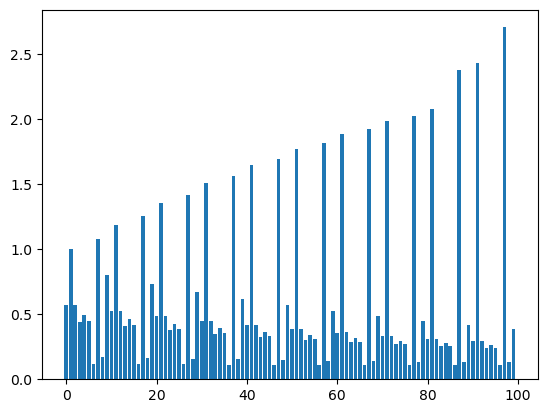

In [20]:
import matplotlib.pyplot as plt

Dtr = np.clip(np.random.randn(100, 10), a_min = 0., a_max=None)
Dte = np.clip(np.random.randn(100, 10), a_min = 0., a_max=None)

pp_kwargs = {
    'obs':      Dtr,
    'kernel_kwargs':    {
        'alpha':    3e-0 * np.eye(Dtr.shape[-1]),
        'beta':     1e-1
    },
    'mu':       1e-1 * np.ones(Dtr.shape[-1])
}

pp_fit_kwargs = {
    'num_epochs':   1000,
    'lr':           1e-3,
    'save_folder':  'cache/discrete_hawkes'  
}

pp = DiscreteHawkes(**pp_kwargs)

# pp.fit(**pp_fit_kwargs)
# pp.load(pp_fit_kwargs['save_folder'])

y = pp.simulate_horizon(history=Dte, horizon=10).reshape(-1)
plt.bar(np.arange(len(y)), y)
plt.show()